---
title: "Seminário de Metodologia de Pesquisa X (PPGP-0114) - 2025/2: Aula 04"
format:
  html:
    toc: true
    toc-title: Sumário
    toc-location: left
    toc-depth: 4
    html-math-method: katex
    code-line-numbers: true
    css: aulas.css
---

* Tema: Análise Computacional de Dados Textuais
* Responsável: Prof. Dr. Hugo Cristo Sant'Anna - [hugo.santanna@ufes.br](mailto:hugo.santanna@ufes.br)

# 3. Medidas e representações contínuas

As matrizes `txd` geradas nos passos anteriores reúnem medidas de *tokens* isolados, sem considerar suas posições nas frases ou relações com outros *tokens*. 

Contudo, uma vez que cada linha (ou vetor) da matriz se refere a um *documento*, pode-se assumir que as colunas (*tokens*) seriam **características** dele. Em outros termos, as relações entre *tokens* e os documentos em que ocorrem, podem codificar aspectos do significado documento.

Pode-se codificar essas relações de diversas formas:

* Frequência absoluta documento: *f*;
* Frequência relativa no documento: a medida *tf*;
* Inverso da frequência no documento na coleção: *idf*;
* Produto *tf-idf*;
* *One hot*: ausência (0) ou presença (1) do termo;
* Outras estratégias baseadas em *redes neurais*.

O que todas essas codificações têm em comum é o uso de vetores *multidimensionais* que *representam* o documento por meio de seus elementos constituintes discretos (*tokens*). No caso da coleção de Machado de Assis, a matriz tem as seguintes características:

* **23** documentos (linhas);
* **14.362** características (colunas ou dimensões do vetor).

Ainda que sejam características geradas a partir de elementos discretos, podemos empregar toda a maquinaria matemática para computar relações entre as representações que construímos para os documentos:

* Distâncias e agrupamentos: funções `dist()` e `hclust()`;
* Correlações: funções `cor()` e `cor.test()`;
* Similaridade: função `cosine()`.

A dificuldade de se trabalhar com representações multidimensionais consiste em visualizá-las, uma vez que a nossa cognição só lida bem com até três dimensões. Para isso, a linguagem R oferece recursos para a *redução* da dimensionalidade, transformando, por exemplo, as 14.362 dimensões em duas (2) ou três (3), o que permite gerar gráficos bi e tridimensionais.

## 3.1 Do discreto para o contínuo

Uma mudança importante acontece ao deixarmos de considerar as características que representam os documentos em termos discretos: os significados de cada característica, bem como sua rotulação, deixam de fazer sentido. Ademais, por razões de economia e eficiência, abandonar o registro discreto da característica nos possibilita restringir a quantidade de dimensões da representação.

Na prática, passaremos a utilizar técnicas de aprendizado de máquina para construir representações de palavras, sentenças e documentos sem que precisemos lidar com cada unidade linguística, de baixo para cima. O processo apresenta amostras do texto a redes neurais para treiná-las nos termos de suas características, que são representadas nos pesos entre as camadas de neurônios artificiais. 

Essas técnicas envolvem conhecimentos matemáticos mais avançados e difíceis de se chegar analiticamente. Felizmente, as funções da linguagem R fazem todo o trabalho e podemos nos concentrar nas análises 😁.

Contudo, antes de utilizar essas funções, exploraremos os limites das representações discretas a técnicas matemáticas mais intuitivas.

## 3.2 Preparação dos dados

Para retomar as análises, carregaremos os resultados dos processamentos gerados na aula anterior (03), sem precisar tratar novamente os dados:

In [1]:
# carrega pacotes necessários
install.packages('openxlsx')
library(openxlsx)

# carrega bases
txd.tf <- read.xlsx("./dados/txd-tf.xlsx")
txd.idf <- read.xlsx("./dados/txd-idf.xlsx")
txd.tfidf <- read.xlsx("./dados/txd-tfidf.xlsx")
txd.tidy <- read.xlsx("./dados/txd-tidy.xlsx")

Installing package into ‘C:/Users/msn/AppData/Local/R/win-library/4.5’
(as ‘lib’ is unspecified)


trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/openxlsx_4.2.8.1.zip'
Content type 'application/zip' length 2496480 bytes (2.4 MB)
downloaded 2.4 MB



package ‘openxlsx’ successfully unpacked and MD5 sums checked



The downloaded binary packages are in
	C:\Users\msn\AppData\Local\Temp\RtmpSaUIn6\downloaded_packages


Warning message:
In file.copy(savedcopy, lib, recursive = TRUE) :
  problem copying C:\Users\msn\AppData\Local\R\win-library\4.5\00LOCK\openxlsx\libs\x64\openxlsx.dll to C:\Users\msn\AppData\Local\R\win-library\4.5\openxlsx\libs\x64\openxlsx.dll: Permission denied
Warning message:
package ‘openxlsx’ was built under R version 4.5.2 


## 3.3 Codificação e representação

A base `txd.tf` consiste na frequência relativa dos *tokens* da coleção. Há uma versão mais simples desta representação, denominada *one-hot*, que apenas sinaliza se um termo ocorreu (valor $1$) ou não ($0$) no documento que integra a coleção e, como resultado, produz cadeias de zeros e uns:

1. *Isto é um exemplo*
2. *Um outro exemplo*

A codificação *one-hot* da coleção teria como resultado a matriz a seguir:

|documento|isto|é  |um |exemplo|outro|representação|
|---------|:--:|:-:|:-:|:-----:|:---:|-------------|
|1        |1   |1|1 |1      |0    |11110|
|2        |0   |0|1 |1      |1    |00111|

Vamos aproveitar `txd.tf` como base para construir outro `data.frame` que emprega a codificação *one-hot*:

In [2]:
# cria df
txd.onehot <- txd.tf

# transforma tf em 0/1
for (linha in 1:nrow(txd.onehot)) {
  # varre colunas
  for (coluna in 1:ncol(txd.onehot)) {
    if (txd.onehot[linha,coluna] > 0) txd.onehot[linha,coluna] <- 1
  }
}

# visualiza df
View(txd.onehot)

Compare as duas matrizes: `txd.tfidf` e `txd.onehot`. A representação do documento nos termos da frequência relativa *tf* e do produto *tf-idf* é fundada em números reais, em vez de ausente ($0$) e presente ($1$). Veremos a seguir que, embora o uso de número reais nas características permita diferenciar melhor os vetores, há técnicas que conseguem agrupar documentos baseados em cada tipo de representação.

Há duas formas de calcular distâncias entre vetores por métricas que nos interessam: *binária assimétrica* e *euclidiana*. 

### Distância binária assimétrica

Também conhecida como [índice de similaridade de Jaccard](https://en.wikipedia.org/wiki/Jaccard_index), esta métrica é específica para calcular o quanto dois conjuntos de dados com características binárias ($0$ ou $1$) têm sobreposição. Para dois documentos $p$ q $q$ com $n$ características que podem estar presentes ou ausentes, o cálculo da distância se inicia pela identificação de quatro casos:

1. $M_{11}$: total de atributos que tanto $p$ quanto $q$ apresentam ($1$)
2. $M_{01}$: total de atributos que $p$ não apresenta ($0$) e que $q$ apresenta ($1$)
2. $M_{10}$: total de atributos que $p$ apresenta ($1$) e que $q$ não apresenta ($0$)
1. $M_{00}$: total de atributos que bem $p$ nem $q$ apresentam ($0$)

O valor de $n$ é igual à soma desses atributos:

$$
n=M_{11} + M_{01} + M_{10} + M_{00}
$$ {#eq-bin1}

A partir disso, o índice de similaridade é calculado por:

$$
J=\frac{M_{11}}{M_{01}+M_{10}+M_{11}}
$$ {#eq-bin2}

E a distância entre $p$ e $q$ é calculada por:

$$
d_J=1-J
$$ {#eq-bin3}

O argumento `method` da função `dist()` pode receber o valor `binary`, referente ao cálculo da distância binária assimétrica. Utilizando a matriz `txd.onehot`, podemos agrupar os documentos em função da ausência ou presença de *tokens* considerados como características:

In [3]:
# -------------------------------------------
# calcula distância entre documentos 1 e 2
# -------------------------------------------

# recupera valores binários das características
doc1 <- as.numeric(txd.onehot[1,])
doc2 <- as.numeric(txd.onehot[2,])

# define Ms
m11 <- 0
m01 <- 0
m10 <- 0
m00 <- 0

# calcula os Ms
for (d in 1:length(doc1)) {
  # caso m11
  if (doc1[d] == 1 && doc2[d] == 1) m11 <- m11 + 1
  # caso m01
  if (doc1[d] == 0 && doc2[d] == 1) m01 <- m01 + 1
  # caso m10
  if (doc1[d] == 1 && doc2[d] == 0) m10 <- m10 + 1
  # caso m00
  if (doc1[d] == 0 && doc2[d] == 0) m00 <- m00 + 1
}

# calcula J
j <- m11 / (m01 + m10 + m11)

# calcula dJ
dj <- 1-j
print(paste("Distância entre 1 e 2:",dj))

# calcula diretamente pela função dist() para comparar
dj2 <- dist(txd.onehot[1:2,],method="binary")
print(paste("Distância entre 1 e 2 via dist():",dj2))

[1] "Distância entre 1 e 2: 0.887337057728119"
[1] "Distância entre 1 e 2 via dist(): 0.887337057728119"


A função `dist()` tem a conveniência de facilitar a análise de inúmeros documentos com características binárias na mesma execução, além de poder ser combinada à instrução `hclust()`, que cria agrupamentos (*clusters*) a partir das distâncias e permite a visualização da árvore resultante:

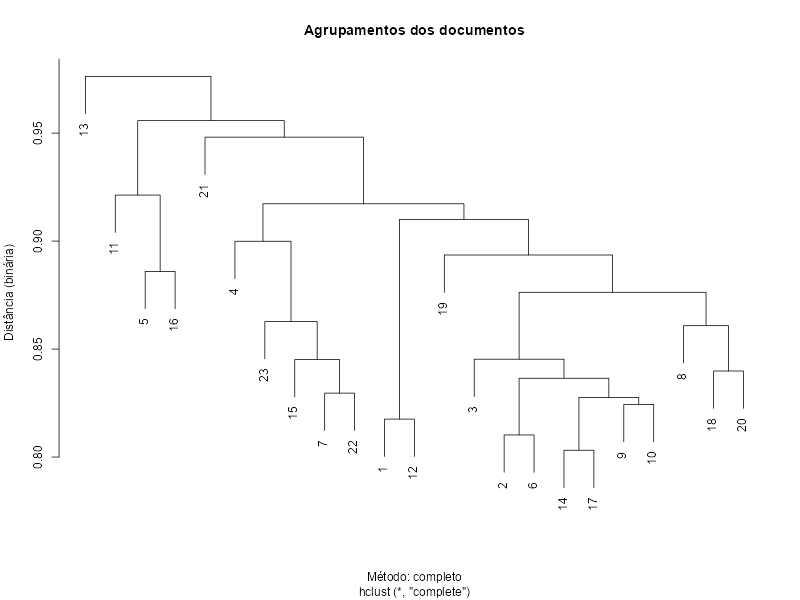

In [4]:
# plota
plot(
  # agrupamentos
  hclust(
    # distância binária
    dist(txd.onehot, method="binary"),
    # método: completo (encontra mais similares)
    method="complete"
  ),
  # título do gráfico
  main="Agrupamentos dos documentos",
  ylab="Distância (binária)",
  xlab="Método: completo"
)

A árvore está dividida em dois grandes grupos, sendo o primeiro (à esquerda), composto pelo documento $13$ &mdash; "O Visconde de Castilho". Na segunda partição, há outras subdivisões tais como aquela mais à esquerda: $11$ ("Fagundes Varela") versus $5$ ("Lúcio de Mendonça: Névoas matutinas") e $16$ ("Francisco de Castro: Harmonias errantes").

> **Dica**: frente a esses resultados, cabe ao pesquisador estudar os documentos e verificar as razões do agrupamento. Pela natureza da codificação (presente/ausente), os documentos compartilham parte importante do vocabulário.

O trecho de código a seguir exibe as distâncias entre os documentos do ramo esquerdo da árvore, lembrando de que *quanto mais próximo de zero, mais similares são os objetos a partir de suas características*. 

In [5]:
# distâncias
dist(txd.onehot[c(13,11,5,16),],method="binary")

          13        11         5
11 0.9402985                    
5  0.9615385 0.9213115          
16 0.9551935 0.9046154 0.8859504

Confirmamos a partição da imagem observando que o documento $13$ está mais distante de $5$ e $16$ que de $11$, embora seja importante notar que os documentos são muito diferentes entre si. Na realidade, como se pode observar, *nenhum* documento dista de outros por menos de $0,80$. 

In [6]:
# menor distância da coleção
min(dist(txd.onehot,method="binary"))

[1] 0.8031496

### Distância euclidiana

A segunda métrica é mais familiar, pois é abordada no ensino médio. A variável $n$ é o número de dimensões ou características na fórmula a seguir:

$$
d=\sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + ... + (p_n - q_n)^2}
$$ {#eq-euclides}

Neste caso, as variáveis $p$ e $q$ também correspondem a dois documentos, porém os índices $\{1, 2, ..., n\}$ indicam as características que informam o cálculo da distância.

Em vez de utilizarmos a matriz `txd.onehot`, calcularemos a distância entre os documentos utilizando a métrica `tf-idf` computada na matriz `txd.tfidf`.

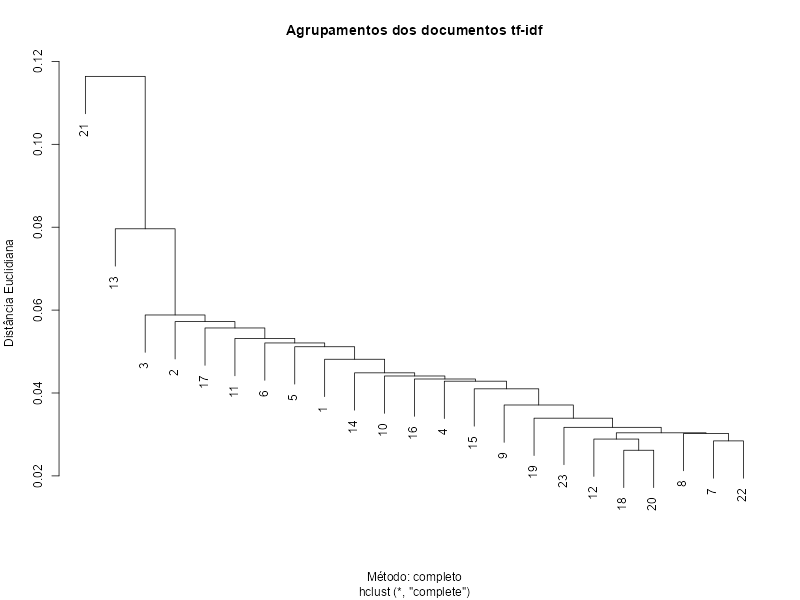

In [7]:
# plota
plot(
  # agrupamentos
  hclust(
    # distância euclidiana
    dist(txd.tfidf, method="euclidean"),
    # método: completo (encontra mais similares)
    method="complete"
  ),
  # título do gráfico
  main="Agrupamentos dos documentos tf-idf",
  ylab="Distância Euclidiana",
  xlab="Método: completo"
)

A métrica *tf-idf* parece representar melhor os documentos e a razão é evidente: a presença ou ausência de uma característica foi substituída por valores contínuos (números reais) que informam a importância de cada *token* para os documentos. Assim, o cálculo de distância incorpora essas nuances e resulta em documentos com até $0,026$ de similaridade.

In [8]:
# distância mínima
min(dist(txd.tfidf,method="euclidean"))

[1] 0.02618726

Vamos analisar o ramo esquerdo da árvore quanto às distâncias entre as terminais:

In [9]:
# distâncias
print(
  dist(
    txd.tfidf[c(21,13,3),],
    method="euclidean"  
  )
)

          21        13
13 0.1163973          
3  0.1041417 0.0796166


### Similaridade de cosseno

Esta é uma métrica de similaridade entre dois vetores, baseada no cosseno do ângulo entre eles. O valor calculado está no intervalo $[-1,+1]$: 

* Valores próximos de $1$ indicam proporcionalidade;
* Vetores ortogonais (90°) têm similaridade em torno de $0$;
* Valores próximos de $-1$ indicam vetores opostos. 

A seguir, testamos o cálculo utilizando os documentos $1$ e $2$ da coleção. Para isso, instalaremos o pacote `lsa` e utilizaremos a função `cosine()`, que recebe como argumentos os dois vetores a serem comparados.

In [10]:
# instala e carrega pacote
install.packages('lsa')
library(lsa)

# seleciona documentos
doc1 <- as.numeric(txd.tfidf[1,])
doc2 <- as.numeric(txd.tfidf[2,])
# calcula
cosine(doc1,doc2)

Installing package into ‘C:/Users/msn/AppData/Local/R/win-library/4.5’
(as ‘lib’ is unspecified)


trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/lsa_0.73.3.zip'
Content type 'application/zip' length 203352 bytes (198 KB)
downloaded 198 KB



package ‘lsa’ successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\msn\AppData\Local\Temp\RtmpSaUIn6\downloaded_packages
Loading required package: SnowballC


Warning message:
package ‘lsa’ was built under R version 4.5.2 


           [,1]
[1,] 0.01461516

O valor resultante (0,014) indica similaridade baixa, com os vetores se aproximando da ortogonalidade (0).

O *script* abaixo demonstra a construção de um `data.frame` que calcula a distância euclidiana e a similaridade de cosseno entre o documento $1$ ("Falenas") e todos os demais da coleção. Este tipo de resultado permite visualizar as métricas lado a lado.

In [11]:
# cria df
similaridade <- data.frame()

# seleciona doc1
doc1 <- as.numeric(txd.tfidf[1,])

# varre banco
for (doc in 2:nrow(txd.tfidf)) {
  # seleciona doc2
  doc2 <- as.numeric(txd.tfidf[doc,])
  # similaridade de cosseno
  doc.cosseno <- as.numeric(cosine(doc1, doc2))
  # distância euclidiano
  doc.euclid <- as.numeric(dist(rbind(doc1,doc2),method="euclidean"))
  # adiciona
  similaridade <- rbind(
    similaridade,
    data.frame(
      "doc1"=1,
      "doc2"=doc,
      "simi.cos"=doc.cosseno,
      "dist.euc"=doc.euclid
    )
  )  
}

# visualiza resultado
View(similaridade)

A matriz resultante compara as duas métricas e contribui para a avaliação da similaridades apoiada por dois índices. O gráfico a seguir exibe as duas métricas da coleção quanto ao documento 1 e sugere que os documentos $12$ ("Americanas") e $8$ ("Badaladas") seriam os mais similares a ele. 

Installing package into ‘C:/Users/msn/AppData/Local/R/win-library/4.5’
(as ‘lib’ is unspecified)


trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/ggplot2_4.0.1.zip'
Content type 'application/zip' length 8479127 bytes (8.1 MB)
downloaded 8.1 MB



package ‘ggplot2’ successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\msn\AppData\Local\Temp\RtmpSaUIn6\downloaded_packages


Warning message:
package ‘ggplot2’ was built under R version 4.5.2 


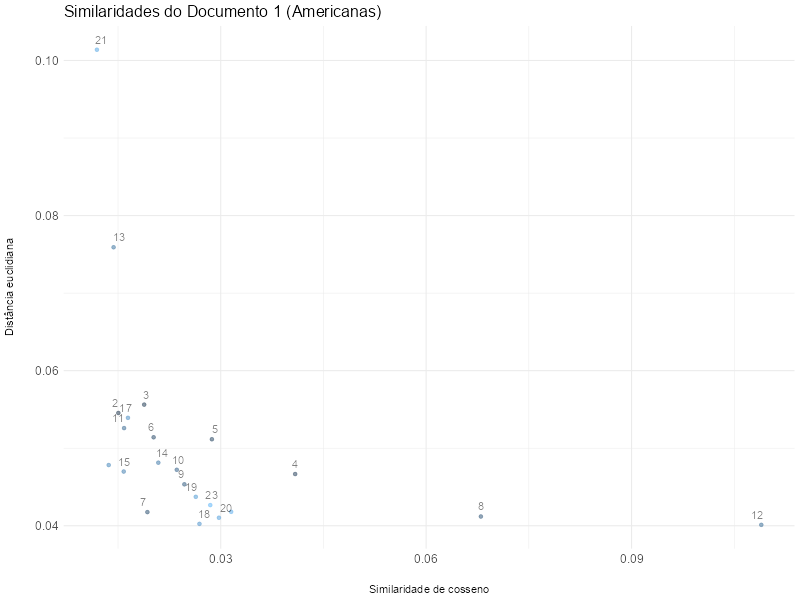

In [12]:
# instala pacotes
install.packages('ggplot2')
# carrega pacotes
library(ggplot2)

# plota
ggplot(similaridade) +
  geom_jitter(aes(x=simi.cos, y=dist.euc, colour=doc2), alpha=0.5, width=0.001) + 
  geom_text(aes(x=simi.cos, y=dist.euc, label=doc2, vjust=-0.75), alpha=0.5, check_overlap = TRUE)+
  labs(title="Similaridades do Documento 1 (Americanas)")+
  xlab("Similaridade de cosseno")+
  ylab("Distância euclidiana")+
  theme_minimal() + 
  theme(
    # título do gráfico
    plot.title = element_text(size=16),
    # fonte e espaçamento do eixo x
    axis.text.x = element_text(size=12),
    axis.title.x = element_text(margin=margin(t=20,b=0,l=0,r=0,unit="pt")),
    # fonte e espaçamento do eixo x
    axis.text.y = element_text(size=12),
    axis.title.y = element_text(margin=margin(t=0,b=0,l=0,r=20,unit="pt")),
    # oculta legenda
    legend.position="none"
  )

Apesar de a distância entre $1$ e $12$ ser pequena (0,04), a similaridade é *baixa* (0,10). Tal diferença nos ajuda reforçar que não é possível compreender as razões da similaridade sem a avaliação qualitativa dos documentos.

# Atividade

Selecione qualquer subconjunto de obras da coleção completa de Machado de Assis (arquivo `machado.xlsx`) ou outra de sua preferência.

1. Calcule a métrica *tf-idf*, as distâncias euclidianas e similaridades de cosseno entre os documentos da coleção;
2. Gere o agrupamento dos documentos pela métrica *tf-idf*;
3. Gere e exporte uma planilha com as distâncias e similaridades;
4. Visualize a relação entre distâncias e similaridades.

> **Dica**: o notebook [aula-04-exemplo.ipynb](./aula-03-exemplo.html) exemplifica *todas* as operações necessárias para dez obras selecionadas aleatoriamente da coleção.